In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
torch.set_default_dtype(torch.float64)
import torch.nn as nn
import copy
import random

In [2]:
import config as cfg
from model import DeepNN
from utils import relative_l2, set_seed
from train_reg import train_model_reg
from train_pde import train_model_pde

In [3]:
set_seed(0)
model_E = DeepNN().cuda()
model_T = DeepNN().cuda()
[model_E, model_T] = train_model_reg(model_E, model_T, Nfit=300, lr_E=1e-3, lr_T=1e-3)

E: lbfgs : 0 - ref_rl2 8.8117e-01 
T: lbfgs : 0 - ref_rl2 5.5702e-01 
E: lbfgs : 50 - ref_rl2 1.8940e-03 
T: lbfgs : 50 - ref_rl2 3.6406e-03 
E: lbfgs : 100 - ref_rl2 3.4281e-04 
T: lbfgs : 100 - ref_rl2 2.4863e-04 
E: lbfgs : 150 - ref_rl2 1.3500e-04 
T: lbfgs : 150 - ref_rl2 7.0998e-05 
E: lbfgs : 200 - ref_rl2 1.1130e-04 
T: lbfgs : 200 - ref_rl2 5.1408e-05 
E: lbfgs : 250 - ref_rl2 1.0569e-04 
T: lbfgs : 250 - ref_rl2 4.2520e-05 
E: lbfgs : 299 - ref_rl2 1.0433e-04 
T: lbfgs : 299 - ref_rl2 3.8226e-05 


In [4]:
set_seed(50)
model_E_cur = DeepNN().cuda()
model_E_cur.load_state_dict(copy.deepcopy(model_E.state_dict()))
model_T_cur = DeepNN().cuda()
model_T_cur.load_state_dict(copy.deepcopy(model_T.state_dict()))
[model_E_cur, model_T_cur] = train_model_pde(model_E_cur, model_T_cur, Nfit=200, lr_E=1e-2, lr_T=1e-2)

E: adam : 0 - ref_rl2 1.0304e-04 - pde 6.8143e-04 - lbc 1.9583e-04 - rbc 2.9585e-03 - tbc 1.5492e-03 - bbc 1.4807e-03
T: adam : 0 - ref_rl2 3.8599e-05 - pde 9.1941e-04 - lbc 3.1901e-06 - rbc 3.0485e-02 - tbc 2.3431e-04 - bbc 1.8995e-04
E: adam : 10 - ref_rl2 4.1707e-05 - pde 3.0315e-04 - lbc 1.5444e-04 - rbc 3.5411e-04 - tbc 7.8196e-04 - bbc 8.4857e-04
T: adam : 10 - ref_rl2 3.9459e-05 - pde 9.1752e-04 - lbc 1.8913e-06 - rbc 3.0439e-02 - tbc 1.8798e-04 - bbc 1.8255e-04
E: adam : 20 - ref_rl2 4.1976e-05 - pde 2.9875e-04 - lbc 1.5489e-04 - rbc 3.6126e-04 - tbc 7.8735e-04 - bbc 8.5343e-04
T: adam : 20 - ref_rl2 1.0959e-05 - pde 9.0346e-04 - lbc 1.5560e-06 - rbc 3.0779e-02 - tbc 4.0828e-05 - bbc 7.9917e-05
E: adam : 30 - ref_rl2 4.1975e-05 - pde 2.9876e-04 - lbc 1.5489e-04 - rbc 3.6125e-04 - tbc 7.8737e-04 - bbc 8.5345e-04
T: adam : 30 - ref_rl2 5.7784e-06 - pde 9.0093e-04 - lbc 1.7592e-06 - rbc 3.1053e-02 - tbc 1.9033e-05 - bbc 3.5471e-05
E: adam : 40 - ref_rl2 4.1974e-05 - pde 2.9876e-04

In [5]:
X = cfg.X.detach().cpu()
Y = cfg.Y.detach().cpu()
E_reg = model_E(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
E_pinn = model_E_cur(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
E_ref = cfg.E_ref.cpu()
T_reg = model_T(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
T_pinn = model_T_cur(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
T_ref = cfg.T_ref.cpu()

In [6]:
print('E: Regression Solution rl2: {:.4e}'.format(relative_l2(E_ref, E_reg)))
print('E: PINN Solution rl2: {:.4e}'.format(relative_l2(E_ref, E_pinn)))

print('T: Regression Solution rl2: {:.4e}'.format(relative_l2(T_ref, T_reg)))
print('T: PINN Solution rl2: {:.4e}'.format(relative_l2(T_ref, T_pinn)))

E: Regression Solution rl2: 1.0433e-04
E: PINN Solution rl2: 4.1970e-05
T: Regression Solution rl2: 3.8226e-05
T: PINN Solution rl2: 4.8864e-06


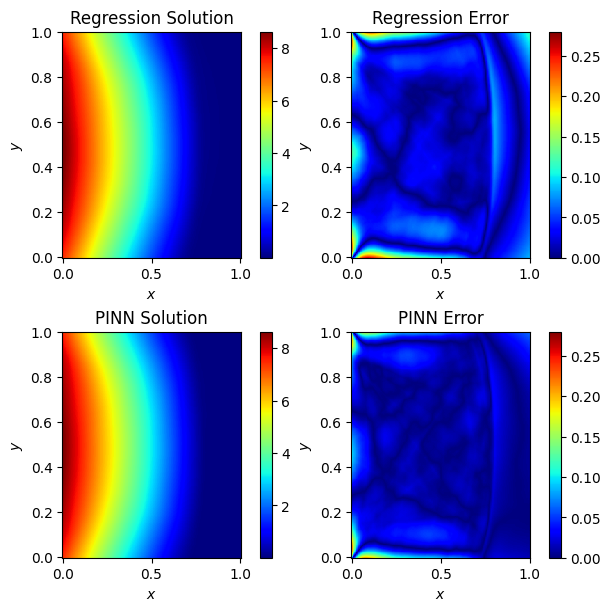

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), layout='constrained')

vmin = E_ref.min()
vmax = E_ref.max()

pcm = axs[0][0].pcolormesh(X, Y, E_reg, vmin=vmin, vmax=vmax, cmap='jet')
axs[0][0].set_title("Regression Solution")
axs[0][0].set_xlabel("$x$")
axs[0][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][0])

pcm = axs[0][1].pcolormesh(X, Y, (E_ref - E_reg).abs(), vmin=0, vmax=0.28, cmap='jet')
axs[0][1].set_title("Regression Error")
axs[0][1].set_xlabel("$x$")
axs[0][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][1])

pcm = axs[1][0].pcolormesh(X, Y, E_pinn, vmin=vmin, vmax=vmax, cmap='jet')
axs[1][0].set_title("PINN Solution")
axs[1][0].set_xlabel("$x$")
axs[1][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][0])

pcm = axs[1][1].pcolormesh(X, Y, (E_ref - E_pinn).abs(), vmin=0, vmax=0.28, cmap='jet')
axs[1][1].set_title("PINN Error")
axs[1][1].set_xlabel("$x$")
axs[1][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][1])

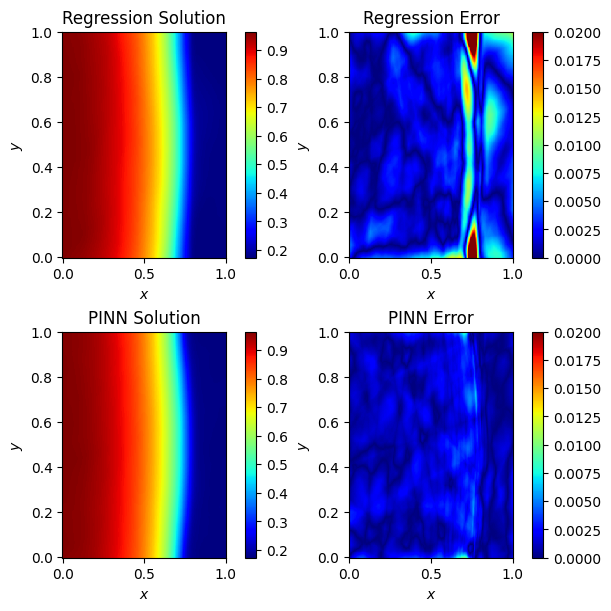

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), layout='constrained')

vmin = T_ref.min()
vmax = T_ref.max()

pcm = axs[0][0].pcolormesh(X, Y, T_reg, vmin=vmin, vmax=vmax, cmap='jet')
axs[0][0].set_title("Regression Solution")
axs[0][0].set_xlabel("$x$")
axs[0][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][0])

pcm = axs[0][1].pcolormesh(X, Y, (T_ref - T_reg).abs(), vmin=0, vmax=0.02, cmap='jet')
axs[0][1].set_title("Regression Error")
axs[0][1].set_xlabel("$x$")
axs[0][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][1])

pcm = axs[1][0].pcolormesh(X, Y, T_pinn, vmin=vmin, vmax=vmax, cmap='jet')
axs[1][0].set_title("PINN Solution")
axs[1][0].set_xlabel("$x$")
axs[1][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][0])

pcm = axs[1][1].pcolormesh(X, Y, (T_ref - T_pinn).abs(), vmin=0, vmax=0.02, cmap='jet')
axs[1][1].set_title("PINN Error")
axs[1][1].set_xlabel("$x$")
axs[1][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][1])